In [48]:
import pandas as pd
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

In [45]:
df = pd.read_csv('data2/unblind_hostz_1.csv', header=None, nrows=100) #, #index_col=False,
print df.shape
print df.columns.values.dtype
df.columns = ['snid', 't', 'ra', 'decl', 'mwebv', 'hostz', 'g', 'gerr', 'r', 'rerr', 'i', 'ierr', 'z', 'zerr', 'sim_z', 'sim_type']
df.head()

(100, 16)
int64


,snid,t,ra,decl,mwebv,hostz,g,gerr,r,rerr,i,ierr,z,zerr,sim_z,sim_type
0,13,0.00000,0.0,-45.524532,0.01,1.14826,0.0,0.151862,2.153496,0.871530,0.0,0.909222,2.980007,2.651292,1.16826,1
1,13,3.00950,0.0,-45.524532,0.01,1.14826,0.0,1.256072,2.153496,0.871530,0.0,1.431373,2.980007,2.651292,1.16826,1
2,13,18.03975,0.0,-45.524532,0.01,1.14826,0.0,1.518787,2.153496,10.103189,0.0,1.858520,2.980007,4.158594,1.16826,1
3,13,31.06725,0.0,-45.524532,0.01,1.14826,0.0,0.249253,3.715618,7.086959,0.0,0.800520,1.509807,2.145532,1.16826,1
4,13,44.86375,0.0,-45.524532,0.01,1.14826,0.0,3.254426,3.141938,6.258898,0.0,1.414858,2.225110,3.055876,1.16826,1


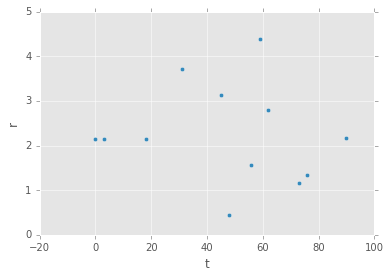

In [50]:
df13 = df[df['snid']==13]
df13.plot.scatter('t', 'r')

In [15]:
from astropy.io import fits
import pandas as pd
import numpy as np

headerIa = fits.open('../MINION_1016_10YR_DDF/LSST_Ia_HEAD.FITS')
headerIa = pd.DataFrame(np.asarray(headerIa[1].data))
print headerIa.shape
headerNonIa = fits.open('../MINION_1016_10YR_DDF/LSST_NONIa_HEAD.FITS')
headerNonIa = pd.DataFrame(np.asarray(headerNonIa[1].data))
print headerNonIa.shape

# Faster to pre-read it all in.
import sncosmo
print 'LOADING PHOTOMETRY...'
snphotIa = sncosmo.read_snana_fits('../MINION_1016_10YR_DDF/LSST_Ia_HEAD.FITS',
                                   '../MINION_1016_10YR_DDF/LSST_Ia_PHOT.FITS', ['13'])

(65732, 79)
(54758, 77)
LOADING PHOTOMETRY...


In [16]:
snphotIa[0]

MJD,FLT,FIELD,TELESCOPE,PHOTFLAG,PHOTPROB,FLUXCAL,FLUXCALERR,MAG,MAGERR,PSF_SIG1,PSF_SIG2,PSF_RATIO,SKY_SIG,SKY_SIG_T,RDNOISE,ZEROPT,ZEROPT_ERR,GAIN,SIM_MAGOBS
float64,str2,str12,str20,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
60902.18,r,NULL,LSST,0,0.0,0.151862,0.909222,29.5464,98.4536,1.66,0.0,0.0,133.32,-9.0,1.12,34.84,0.005,1.0,32.7483
60902.195,i,NULL,LSST,0,0.0,0.098467,1.48598,99.0,5.0,1.56,0.0,0.0,182.5,-9.0,1.12,34.58,0.005,1.0,99.0
60902.203,z,NULL,LSST,0,0.0,-1.06968,2.10891,128.0,0.0,1.5,0.0,0.0,259.63,-9.0,1.27,34.54,0.005,1.0,30.9034
60902.215,Y,NULL,LSST,0,0.0,-1.83369,7.79864,128.0,0.0,1.46,0.0,0.0,320.67,-9.0,1.12,33.32,0.005,1.0,30.1262
60905.156,r,NULL,LSST,0,0.0,-0.922795,1.15918,128.0,0.0,2.45,0.0,0.0,109.99,-9.0,1.12,34.79,0.005,1.0,31.6493
60905.172,i,NULL,LSST,0,0.0,-0.810218,1.93806,99.0,5.0,2.27,0.0,0.0,159.12,-9.0,1.12,34.55,0.005,1.0,99.0
60905.184,z,NULL,LSST,0,0.0,0.87153,2.65129,27.6493,100.351,2.16,0.0,0.0,222.51,-9.0,1.27,34.52,0.005,1.0,29.622
60905.195,Y,NULL,LSST,0,0.0,0.107521,11.0751,29.9213,98.0787,2.07,0.0,0.0,318.25,-9.0,1.12,33.31,0.005,1.0,28.9753
60920.199,r,NULL,LSST,0,0.0,1.51879,1.85852,27.0463,100.954,2.94,0.0,0.0,161.1,-9.0,1.12,34.89,0.005,1.0,28.63


In [66]:
header = headerIa
snphot = snphotIa[0]
ind = 0
snid = '13'

sim_type = header.ix[ind].SIM_TYPE_NAME.strip()
print ind, snid, sim_type

filters = np.array([i[-1] for i in header.columns.values if i.startswith('SIM_PEAKMAG_')])

sn_type = header.ix[ind].SNTYPE
sim_type = header.ix[ind].SIM_TYPE_NAME.strip()
sim_z = header.ix[ind].SIM_REDSHIFT_HELIO
ra = header.ix[ind].RA
decl = header.ix[ind].DECL
mwebv = header.ix[ind].MWEBV
hostid = header.ix[ind].HOSTGAL_OBJID
hostz = header.ix[ind].HOSTGAL_PHOTOZ
spec = header.ix[ind].HOSTGAL_SPECZ

data = pd.DataFrame(np.asarray(snphot))
data = data.query('MAG < 99')
if data.shape[0] <= 0:
        raise Exception
survey = data.TELESCOPE.values[0]
data = data[['MJD','FLT','FLUXCAL','FLUXCALERR']]
print data['FLT'].unique()

flts = np.array(data.FLT.unique())
not_there = filters[~np.in1d(filters, flts)]
for f in not_there:
        tmp = pd.DataFrame(data.iloc[0]).transpose()
        tmp[:] = np.nan
        tmp.FLT = f
        data = data.append(tmp, ignore_index=True)

obs = pd.pivot_table(data, ['FLUXCAL', 'FLUXCALERR'], ['FLT', 'MJD'], dropna=False)
obs = obs.fillna(-999.)
print obs.shape
print data['FLT'].unique()
for f in data['FLT'].unique():
    print obs.loc[f].shape
    
flux_norm = 1.0
time_norm = 1.0
t_arr = obs.loc[flts[0]].index.values #[obs[i][0] for i in xrange(len(obs))]
t_arr = (t_arr - t_arr.min())/time_norm
g_arr = obs.loc['g'].FLUXCAL.values/flux_norm #[obs[i][1] for i in xrange(len(obs))]
g_err_arr = obs.loc['g'].FLUXCALERR.values/flux_norm #[obs[i][5] for i in xrange(len(obs))]
r_arr = obs.loc['r'].FLUXCAL.values/flux_norm #[obs[i][2] for i in xrange(len(obs))]
r_err_arr = obs.loc['r'].FLUXCALERR.values/flux_norm #[obs[i][6] for i in xrange(len(obs))]
i_arr = obs.loc['i'].FLUXCAL.values/flux_norm #[obs[i][3] for i in xrange(len(obs))]
i_err_arr = obs.loc['i'].FLUXCALERR.values/flux_norm #[obs[i][7] for i in xrange(len(obs))]
z_arr = obs.loc['z'].FLUXCAL.values/flux_norm #[obs[i][4] for i in xrange(len(obs))]
z_err_arr = obs.loc['z'].FLUXCALERR.values/flux_norm #[obs[i][8] for i in xrange(len(obs))]

print len(t_arr)

0 13 Ia
['r' 'z' 'Y' 'i']
(210, 2)
['r' 'z' 'Y' 'i' 'u' 'g']
(35, 2)
(35, 2)
(35, 2)
(35, 2)
(35, 2)
(35, 2)
35


In [73]:
def index_min(values):
	'''
	Return the index of an array.
	* values is an array (intended to be times)
	- Used in time_collector() for grouping times
	- Used in parser_spline() for placing flux errors at the correct time in the time sequence
	'''
	return min(xrange(len(values)),key=values.__getitem__)

def time_collector(arr,frac=grouping):
	'''
	Returns the an array of average times about clustered observation times. Default grouping is
	for times on the order of 1 day, although this is reduced if there are too many observations
	in that time. Also returns the index of the indices of the closest times in each flux band
	and the grouping fraction.
	* arr is an array containing all of the observation times
	* frac is the clustering scale where frac=1 is group times within a day
	* a is the array of grouped times
	- Used in parser_spline() for grouping flux errors to the nearest grouped time
	- Used in parser_augment() for grouping times from all observations
	'''
	bestclustering = True
	while bestclustering:
		a = []
		for key, group in groupby(arr, key=lambda n: n//(1./frac)):
			s = sorted(group)
			a.append(np.sum(s)/len(s)) 
		ind = []
		i = 0
		for key,group in groupby(arr, key=lambda n: n//(1./frac)):
			ind.append([])
			for j in group:
				ind[i].append(index_min(abs(j-np.array(arr))))
			i += 1
		if len([len(i) for i in ind if len(i)>4])!=0:
			frac += 0.1
		else:
			bestclustering = False
	return a,ind,frac

def create_colourband_array(ind,arr,err_arr,temp_arr,err_temp_arr):
	'''
	Returns arrays containing the all of the flux observations, all of the flux error observations
	and an option to check that times are grouped such that there is only one observation in a
	cluster of times.
	* ind is the list of indices containing the nearest grouped time for each observation
	* arr is array of all of the flux observations at all observation times
	* err_arr is the array of all of the flux error observations at all observation times
	* temp_arr is the array containing the fluxes at grouped times
	* temp_err_arr is the array containing the flux errors at grouped times
	* out is a boolean which is True if there is only one observation per grouped time and False
	  if there is more than one grouped time - the grouping factor is then reduced.
	- Used in parser_augment() to create the flux and flux error arrays at grouped times
	'''
	temp = [arr[ind[i]] for i in xrange(len(ind)) if arr[ind[i]]!=-999]
	err_temp = [err_arr[ind[i]] for i in xrange(len(ind)) if err_arr[ind[i]]!=-999]
	if len(temp)==0:
		temp_arr.append(-999)
		err_temp_arr.append(-999)
		out = True
	elif len(temp)>1:
		out = False
	else:
		temp_arr.append(temp[0])
		err_temp_arr.append(err_temp[0])
		out = True
	return temp_arr,err_temp_arr,out

def fill_in_points(arr,err_arr):
	'''
	Returns flux and flux error arrays where missing data is filled in with a random value between
	the previous and the next filled array elements. Missing intial or final data is filled in with
	the first or last non-missing data value respectively.
	* arr is the array of fluxes
	* err_arr is the array of flux errors
	- Used in parser_augment() to fill in missing data in flux and flux error arrays.
	'''
	ind = np.where(np.array(arr)!=-999)[0]
	length = len(arr)
	if len(ind)==0:
		arr = [0 for i in xrange(length)]
		err_arr = [0 for i in xrange(length)]
	else:
		for i in xrange(len(ind)-1):
			diff = ind[i+1]-ind[i]
			arr[ind[i]+1:ind[i+1]] = np.random.uniform(arr[ind[i]],arr[ind[i+1]],diff-1)
			err_arr[ind[i]+1:ind[i+1]] = np.random.uniform(err_arr[ind[i]],err_arr[ind[i+1]],diff-1)
		for i in xrange(len(arr[:ind[0]])):
			arr[i] = arr[ind[0]]
			err_arr[i] = err_arr[ind[0]]
		for i in xrange(len(arr[ind[-1]+1:])):
			arr[ind[-1]+1+i] = arr[ind[-1]]
			err_arr[ind[-1]+1+i] = err_arr[ind[-1]]
	return arr,err_arr

In [74]:
from itertools import groupby

correctplacement = True
grouping = 1
frac = grouping
j = 0
while correctplacement:
    t,index,frac = time_collector(t_arr,frac) 
    g_temp_arr = []
    g_err_temp_arr = []
    r_temp_arr = []
    r_err_temp_arr = []
    i_temp_arr = []
    i_err_temp_arr = []
    z_temp_arr = []
    z_err_temp_arr = []
    tot = []
    for i in xrange(len(index)):
        g_temp_arr,g_err_temp_arr,gfail = create_colourband_array(index[i],g_arr,g_err_arr,g_temp_arr,g_err_temp_arr)
        r_temp_arr,r_err_temp_arr,rfail = create_colourband_array(index[i],r_arr,r_err_arr,r_temp_arr,r_err_temp_arr)
        i_temp_arr,i_err_temp_arr,ifail = create_colourband_array(index[i],i_arr,i_err_arr,i_temp_arr,i_err_temp_arr)
        z_temp_arr,z_err_temp_arr,zfail = create_colourband_array(index[i],z_arr,z_err_arr,z_temp_arr,z_err_temp_arr)
        tot.append(gfail*rfail*ifail*zfail)
    if all(tot):
        correctplacement = False
    else:
        frac += 0.1

In [86]:
print len(r_arr), len(r_temp_arr)
print np.sum(np.array(r_arr)> -999)
print np.sum(np.array(r_temp_arr)> -999)
print r_arr
print r_temp_arr
obs.loc['r']

35 12
7
12
[  1.51861504e-01  -9.99000000e+02  -9.99000000e+02   1.51878667e+00
  -9.99000000e+02  -9.99000000e+02  -9.99000000e+02   2.49253243e-01
  -9.99000000e+02  -9.99000000e+02  -9.99000000e+02   3.25442553e+00
  -9.99000000e+02  -9.99000000e+02  -9.99000000e+02  -9.99000000e+02
  -9.99000000e+02  -9.99000000e+02  -9.99000000e+02  -9.99000000e+02
  -9.99000000e+02  -9.99000000e+02  -9.99000000e+02   9.58451629e-02
  -9.99000000e+02  -9.99000000e+02  -9.99000000e+02   1.46912962e-01
  -9.99000000e+02  -9.99000000e+02  -9.99000000e+02   1.85349190e+00
  -9.99000000e+02  -9.99000000e+02  -9.99000000e+02]
[0.15186150372028351, 0.50981701345261143, 1.5187866687774658, 0.24925324320793152, 3.2544255256652832, 1.1066877758666975, 2.8425302000551702, 2.3560200373782134, 0.095845162868499756, 0.14691296219825745, 1.8534919023513794, 1.8534919023513794]


,FLUXCAL,FLUXCALERR
MJD,,
60902.180,0.151862,0.909222
60905.184,-999.000000,-999.000000
60905.195,-999.000000,-999.000000
60920.199,1.518787,1.858520
60920.215,-999.000000,-999.000000
60920.227,-999.000000,-999.000000
60920.238,-999.000000,-999.000000
60933.227,0.249253,0.800520
60933.242,-999.000000,-999.000000


In [89]:
data[data.FLT == 'r']

,MJD,FLT,FLUXCAL,FLUXCALERR
0,60902.180,r,0.151862,0.909222
3,60920.199,r,1.518787,1.858520
7,60933.227,r,0.249253,0.800520
11,60947.023,r,3.254426,1.414858
23,60964.020,r,0.095845,0.832614
27,60975.070,r,0.146913,0.800196
31,60978.074,r,1.853492,1.504471


In [83]:
g_temp_arr,g_err_temp_arr = fill_in_points(g_temp_arr,g_err_temp_arr)
r_temp_arr,r_err_temp_arr = fill_in_points(r_temp_arr,r_err_temp_arr)
i_temp_arr,i_err_temp_arr = fill_in_points(i_temp_arr,i_err_temp_arr)
z_temp_arr,z_err_temp_arr = fill_in_points(z_temp_arr,z_err_temp_arr)
print len(r_temp_arr)
print r_temp_arr

12
[0.15186150372028351, 0.50981701345261143, 1.5187866687774658, 0.24925324320793152, 3.2544255256652832, 1.1066877758666975, 2.8425302000551702, 2.3560200373782134, 0.095845162868499756, 0.14691296219825745, 1.8534919023513794, 1.8534919023513794]
